In [1]:
# Import required modules
import boto3
import os
import json
import time
import matplotlib.pyplot as plt
from PIL import Image
from core_lib.math_question_generation import Analyticsfunction, mathquestion


2024-09-09 22:34:09.814 INFO    botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials


In [2]:

# Initialize AWS services
s3 = boto3.client('s3')

# Global variable to store the summary
summary = ""

# Define S3 bucket
bucket_name = 'document-tender'

# Math question generation
math = mathquestion()

def create_image1(question):
    prompt = f'''Human: Please create a Python script to generate an informative and visually appealing image representing the mathematical concept or problem: {question}
                Please follow these guidelines:
                1. Use the seaborn package to create the plot, and save it as "image.jpg" with a resolution of 100 dpi.
                2. Ensure the code must be complete in all aspects.
                3. Ensure the image covers approximately 80% of the area, leaving space for labels.
                4. Complete all edges and align them properly for the chosen shape or representation.
                5. Label relevant components (e.g., edges, vertices, angles) with clear annotations for better understanding.
                6. Import all necessary libraries and functions required for the task.
                7. The code should be accurate, well-structured, and easy to understand.
                8. Consider using color, shading, and other visual elements to enhance the clarity and aesthetics of the image.
                Assistant:'''

    body = json.dumps({"prompt": prompt})
    text = math.call_claude_sonet_text_s35(body)
    return text


2024-09-09 22:34:09.909 INFO    botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
import time

def create_image(question):
    text = create_image1(question)
    
    prompt2 = f'''Human: Your task is Check the correctness and review the the Python code /n {text} and make sure no library import is missing,rewrite the updated code but don't change the important section of the code.
                Assistant:'''
    
    body2 = json.dumps({"prompt": prompt2})
    
    text2 = math.call_claude_sonet_text(body2)

    # Save code to a file
    image_name = "image.jpg"
    output_file = "main.py"
    math.extract_python_code(text2, output_file)
    
    # Execute the script
    os.system(f"python3 {output_file}")

    # Check if the image file exists
    if os.path.isfile(image_name):
        img = Image.open(image_name)
        # Upload image to S3 bucket
        s3.upload_file(image_name, bucket_name, image_name)
        image_url = f"https://{bucket_name}.s3.amazonaws.com/{image_name}"
        return img
    else:
        print(f"Error: Image file '{image_name}' not found.")
        return None

In [4]:

# Translate function
def translate(text, source_lang='en', target_lang='hi'):
    translate = boto3.client(service_name='translate', region_name='us-east-1')
    result = translate.translate_text(Text=text, SourceLanguageCode=source_lang, TargetLanguageCode=target_lang)
    return result.get('TranslatedText')

# JSON extraction function
def extract_json(response):
    try:
        start_index = response.find('{')
        end_index = response.rfind('}') + 1
        json_data = response[start_index:end_index]
        data = json.loads(json_data)
        return data
    except (ValueError, TypeError):
        print("Error: Invalid JSON data")
        return None


In [5]:
question = "ABCDEF is a hexagon. Find the value of AB+BC+CD+DE+AF+FE+AE ?"

question1 = "If the position vectors of the vertices A, B, and C of a triangle △ABC are αi+βj+γk, βi+γj+αk, and γi+αj+βk respectively, then △ABC is ?"

question2 = "What is area of rectangle?"

In [6]:

# Ask question
# question = "What is the area of a triangle?"
img = create_image(question1)


Figure(1000x800)


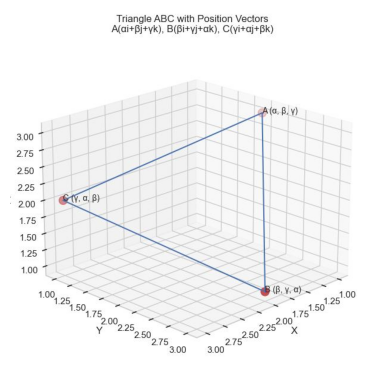

In [7]:

# Display image if exists
if img:
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [8]:

# Summarization process from uploaded text file
def summarize_text(input_file_path, target_lang='en'):
    with open(input_file_path, 'r') as file:
        text = file.read()
        
    # Summarize the text
    obj = Analyticsfunction()
    claude3 = obj.call_claude_sonet_text
    math = mathquestion()
    summary = math.create_summary(text)
    
    # Translate summary
    translated_summary = translate(summary, target_lang=target_lang)
    
    # Save the summary to file
    with open('summary.txt', 'w') as f:
        f.write(translated_summary)

    # Upload to S3
    s3.upload_file('summary.txt', bucket_name, 'summary.txt')
    summary_url = f"https://{bucket_name}.s3.amazonaws.com/summary.txt"
    
    return translated_summary


In [9]:
# For summarization, provide the file path
input_file_path = "/Users/tiwarysa/Documents/mathimage-hackthon/document/sample1.txt" 

#input_file_path = "/Users/tiwarysa/Documents/mathimage-hackthon/document/class7-math-topics.txt"
#input_file_path = "/Users/tiwarysa/Documents/mathimage-hackthon/document/video_text.txt" 
# Replace with your local file path
summarized_text = summarize_text(input_file_path)
print(f"Summarized Text: {summarized_text}")

# Q&A based on summarized text
def generate_questions(summary, num_questions=5, target_lang='en', delay=1):
    prompt = f'''Human: Please generate {num_questions} number of multiple-choice question and their respective answers based on the content provided in the attached document. The questions should cover a range of difficulty levels (easy, medium, and hard) and test different aspects of the content, such as factual information, concepts, and analysis. Each question should have 4 answer choices, with only one correct answer. Please include question, options, answer, and explanation. 
    <book>
    {summary}
    </book>
    Please create the response in JSON format.
    Assistant:'''
    
    body = json.dumps({"prompt": prompt})
    question_data = math.question_answer_generation(body)
    json_data = extract_json(question_data)

    # Translate and display questions
    for i, question in enumerate(json_data["questions"]):
        translated_question = translate(question['question'], target_lang=target_lang)
        print(f"Question {i+1}: {translated_question}")
        img = create_image(question['question'])
        if img:
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        print(f"Options: {question['options']}")
        print(f"Answer: {question['answer']}")
        #print(f"Explanation: {translate(question['explanation'], target_lang=target_lang)}")
        print("-" * 40)
        
        # Add delay between questions
        time.sleep(delay)

Summarized Text: Here is a summary of the document in around 1000 words:

The document provides a comprehensive explanation of the concepts of area and perimeter for Class 7 level mathematics. It starts by defining area as the amount of space inside the boundaries of a 2-dimensional shape, measured in square units, and perimeter as the distance around the outside of a 2-dimensional shape, measured in linear units. Understanding these concepts is crucial for many real-world applications.

The document then explains how to calculate the perimeter of various shapes, including rectangles/squares, triangles, regular polygons, and circles. For area calculations, it covers rectangles, squares, triangles, circles, parallelograms, and trapezoids, providing formulas and examples for each shape.

The explanation delves deeper into each shape, offering problem-solving techniques such as drawing diagrams, identifying given information, choosing the correct formula, showing work, including units, an

{
  "questions": [
    {
      "question": "What is the difference between area and perimeter?",
      "options": [
        "A. Area is the amount of space inside a shape, while perimeter is the distance around the outside of a shape.",
        "B. Area is the distance around the outside of a shape, while perimeter is the amount of space inside a shape.",
        "C. Area and perimeter are the same thing.",
        "D. Area is measured in square units, while perimeter is measured in linear units."
      ],
      "answer": "A",
      "explanation": "The document clearly defines area as the amount of space inside the boundaries of a 2-dimensional shape, measured in square units, and perimeter as the distance around the outside of a 2-dimensional shape, measured in linear units."
    },
    {
      "question": "What is the formula for calculating the area of a rectangle?",
      "options": [
        "A. A = l × w",
        "B. A = 2 × (l + w)",
        "C. A = l × h",
        "D. A = π × r^2"
      ],
      "answer": "A",
      "explanation": "The document states that the formula for calculating the area of a rectangle is A = l × w, where l is the length and w is the width."
    },
    {
      "question": "If the radius of a circle is 5 cm, what is the approximate area of the circle? (Use π = 3.14)",
      "options": [
        "A. 31.4 cm^2",
        "B. 78.5 cm^2",
        "C. 62.8 cm^2",
        "D. 15.7 cm^2"
      ],
      "answer": "B",
      "explanation": "The formula for the area of a circle is A = π × r^2, where r is the radius. Substituting the given values, we get A = 3.14 × (5 cm)^2 = 78.5 cm^2."
    },
    {
      "question": "What is the formula for calculating the area of a parallelogram?",
      "options": [
        "A. A = b × h",
        "B. A = 1/2 × b × h",
        "C. A = b × l",
        "D. A = 1/2 × (a + b) × h"
      ],
      "answer": "B",
      "explanation": "The document states that the formula for calculating the area of a parallelogram is A = b × h, where b is the base and h is the height (or altitude)."
    },
    {
      "question": "If the base of a triangle is 8 cm and the height is 6 cm, what is the area of the triangle?",
      "options": [
        "A. 24 cm^2",
        "B. 48 cm^2",
        "C. 14 cm^2",
        "D. 28 cm^2"
      ],
      "answer": "B",
      "explanation": "The formula for the area of a triangle is A = 1/2 × b × h, where b is the base and h is the height. Substituting the given values, we get A = 1/2 × 8 cm × 6 cm = 24 cm^2."
    }
  ]
}

Question 1: What is the difference between area and perimeter?


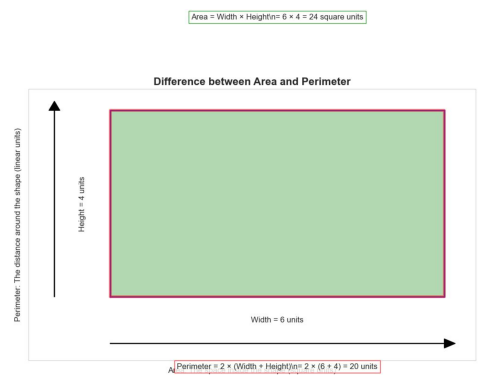

Options: ['A. Area is the amount of space inside a shape, while perimeter is the distance around the outside of a shape.', 'B. Area is the distance around the outside of a shape, while perimeter is the amount of space inside a shape.', 'C. Area and perimeter are the same thing.', 'D. Area is measured in square units, while perimeter is measured in linear units.']
Answer: A
----------------------------------------
Question 2: What is the formula for calculating the area of a rectangle?
Image has been saved as 'image.jpg'


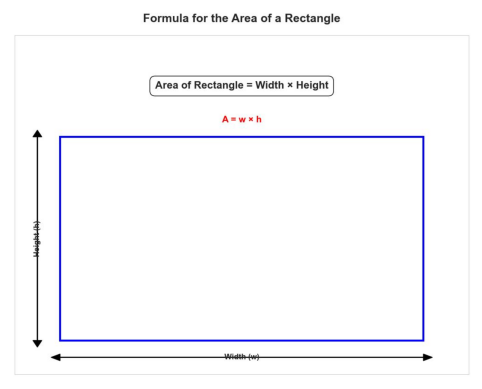

Options: ['A. A = l × w', 'B. A = 2 × (l + w)', 'C. A = l × h', 'D. A = π × r^2']
Answer: A
----------------------------------------
Question 3: If the radius of a circle is 5 cm, what is the approximate area of the circle? (Use π = 3.14)


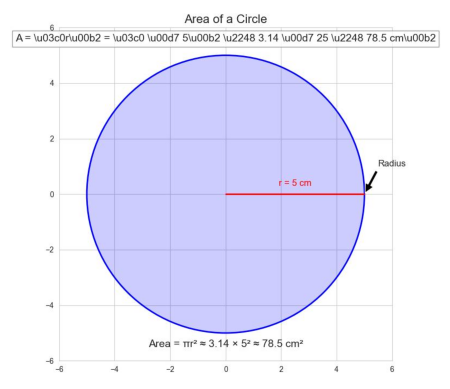

Options: ['A. 31.4 cm^2', 'B. 78.5 cm^2', 'C. 62.8 cm^2', 'D. 15.7 cm^2']
Answer: B
----------------------------------------
Question 4: What is the formula for calculating the area of a parallelogram?


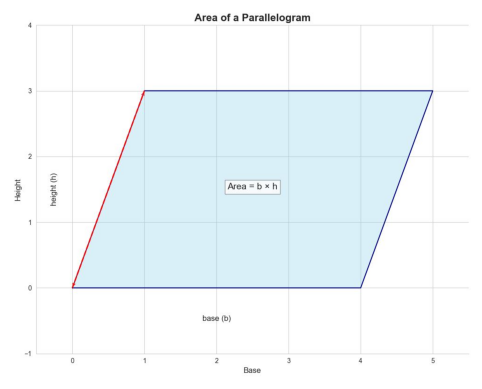

Options: ['A. A = b × h', 'B. A = 1/2 × b × h', 'C. A = b × l', 'D. A = 1/2 × (a + b) × h']
Answer: B
----------------------------------------
Question 5: If the base of a triangle is 8 cm and the height is 6 cm, what is the area of the triangle?


In [10]:

# Call the function
print(generate_questions(summarized_text, num_questions=5, target_lang='en', delay=1))